In [ ]:
!pip install pythainlp

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
pos_text = ("/content/Positive.csv")
neg_text = ("/content/Negative.csv")
neu_text = ("/content/Neutrally.csv")

In [ ]:
pos_df = pd.read_csv(pos_text, delimiter=',', encoding='utf-8').dropna()
neg_df = pd.read_csv(neg_text, delimiter=',', encoding='utf-8').dropna()
neu_df = pd.read_csv(neu_text, delimiter=',', encoding='utf-8').dropna()

data = pd.concat([pos_df, neg_df, neu_df])
data.sample(100)

,User,Message,Sentiment
1305,0***7,สั่งอีกลายได้อีกลายเห้อ,Negative
150,B***.,พัสดุจัดส่งรวดเร็วมากค่ะ แพ็คเก็จเรียบร้อยดี ส...,Positive
209,0***8,ผ้าเช็ดขนาดมาตรฐาน เนื้อนุ่มดีสีสวย ครบจำนวนตา...,Positive
810,รัชนี ส.,น้ำหนัก เอวได้แต่ขาเล็กไปนิดค่ะ เนื้อผ้าดี โอเ...,Neutrally
329,C***.,เอวยางยืดทรงพอดี เหมาะสำหรับกิจกรรมกีฬา ผ้าสบา...,Negative
...,...,...,...
193,*******731,แพคเกจจิ้งดี จัดส่งไว ไม่มีการบุบสลายของสินค้า...,Positive
1492,M***t,เขียวสะท้อนแสง ทางร้านส่งมาผิดไซส์ทำการคืนเงิน...,Positive
551,Charnchai C.,กางเกงที่ตัดเย็บไม่มาตราฐานเสียดายเงิน,Negative
643,pattanachat,วัสดุ ขนาด การออกแบบ,Positive


In [ ]:
from pythainlp.tokenize import word_tokenize

In [ ]:
# สร้างฟังก์ชันสำหรับการลบอักขระที่ซ้ำกันในแต่ละคำเท่านั้น
def remove_duplicate_chars(text):
    if isinstance(text, str):  # ตรวจสอบว่าข้อความไม่ใช่ NaN
        unique_words = []
        words = word_tokenize(text)
        for word in words:
            unique_word = ''
            for char in word:
                if char not in unique_word:
                    unique_word += char
            unique_words.append(unique_word)
        return ' '.join(unique_words)
    else:
        return text  # ส่งค่า NaN กลับหากเป็น NaN

# ใช้ฟังก์ชัน `remove_duplicate_chars` เพื่อ Tokenize และลบคำที่ซ้ำ
data['Message'] = data['Message'].apply(remove_duplicate_chars)
data.sample(10)

,User,Message,Sentiment
182,B***.,วัสดุ คุณภาพ ดีมาก,Positive
326,ณัฐพัชร์ ร.,มีด สี ยง สะท้อน,Neutrally
935,0***6,สัง ่ อัน ได้ อัน เดียว,Negative
1450,S***.,พอใช้ได,Neutrally
347,Oh Y.,ตัว ใหญ่ ผ้า บาง,Negative
409,สุกัญญา พ.,เสียง เบา ไป หน่อย,Neutrally
7,C***.,ตาม ราค,Positive
355,เล'ดิ้'ด- เ.,ใส่ ได้ พอดี ค่ะ ไม่ หลวม ไม่ แน่ ค่ะ แต่ ถ้า ...,Positive
1201,ภ***์,สบาย และ ดูี คุ้ม่า กับ รา คาที่ ดี เหมาะส...,Neutrally
811,C***t,สินค้า คุณภาพดี ราค เหมาะส การจัดเตียม สิน...,Positive


In [ ]:
Message = data['Message'].values
Sentiment = data['Sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(Sentiment)
print("Encoded labels:", encoded_labels)
print("Mapping of encoded labels to original labels:")

for label, original_label in enumerate(encoder.classes_):
    print(f"{label}: {original_label}")

Encoded labels: [2 2 2 ... 1 1 1]
Mapping of encoded labels to original labels:
0: Negative
1: Neutrally
2: Positive


In [ ]:
# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
train_sentences, test_sentences, train_labels, test_labels = train_test_split(Message, encoded_labels, stratify=encoded_labels, test_size=0.1, random_state=42)

In [ ]:
val_size = int(len(test_sentences)/2)
train = list(train_sentences)[:(len(train_sentences)-val_size)]
val = list(train_sentences)[(len(train_sentences)-val_size):]
test = list(test_sentences)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

#ใช้ชุดเทรน ทำ vectorizer
tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = torch.tensor(tfidfX_train.toarray())

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = torch.tensor(tfidfX_val.toarray())

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = torch.tensor(tfidfX_test.toarray())

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: torch.Size([3816, 1000])
TF-IDF test shape: torch.Size([450, 1000])
TF-IDF val shape: torch.Size([225, 1000])


In [ ]:
Y_train = torch.squeeze(torch.tensor(list(train_labels[:(len(train_sentences)-val_size)])).float())
Y_val = torch.squeeze(torch.tensor(train_labels[(len(train_sentences)-val_size):]).float())
Y_test = torch.squeeze(torch.tensor(test_labels).float())

print("Y train shape:", Y_train.shape)
print("Y test shape:", Y_val.shape)
print("Y shape:", Y_test.shape)

Y train shape: torch.Size([3816])
Y test shape: torch.Size([225])
Y shape: torch.Size([450])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FFNN, self).__init__()

        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [ ]:
# Define the number of classes
num_classes = 3

# Define the input and hidden dimensions
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512
hidden_dim_2 = 512
output_dim = num_classes

# Define the model with the appropriate output dimension
first_model = FFNN(input_dim, hidden_dim_1, hidden_dim_2, num_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = optim.Adam(first_model.parameters(), lr=0.1e-4, weight_decay=1e-3)

# Transfer the model to the GPU if available
first_model.to(device)

FFNN(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=3, bias=True)
)

In [ ]:
from tqdm import tqdm

# Define the function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float()
    acc = correct.sum() / len(correct)
    return acc

# Define batch size
batch_size = 16

# Split train dataset into mini-batches
X_train_mini_batches = torch.split(tfidfX_train, batch_size)
Y_train_mini_batches = torch.split(Y_train, batch_size)

# Initialize lists to store losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
min_loss = float('inf')

# Start training
for epoch in range(num_epochs):
    print('epoch', epoch)
    epoch_loss = 0
    epoch_accuracy = 0

    for X_train_mini_batch, Y_train_mini_batch in tqdm(zip(X_train_mini_batches, Y_train_mini_batches)):
        X_train_mini_batch = X_train_mini_batch.to(device)
        Y_train_mini_batch = Y_train_mini_batch.to(device)

        # Forward pass to get output
        train_prediction = first_model(X_train_mini_batch.float())

        # Calculate Loss
        train_loss = criterion(train_prediction, Y_train_mini_batch.long())  # Convert Y_train_mini_batch to long type

        # Clearing up accumulated gradients
        optimizer.zero_grad()

        # Getting gradients
        train_loss.backward()

        # Updating parameters
        optimizer.step()

        # Add each mini batch's loss
        epoch_loss += train_loss.item()

        # Add each mini batch's accuracy
        epoch_accuracy += calculate_accuracy(Y_train_mini_batch, train_prediction)

    # Print loss and accuracy for some epochs
    if epoch % 1 == 0:
        tfidfX_val = tfidfX_val.to(device)
        Y_val = Y_val.to(device)

        # Forward pass to get output
        val_prediction = first_model(tfidfX_val.float())

        # Calculate Loss
        val_loss = criterion(val_prediction, Y_val.long())  # Convert Y_val to long type

        epoch_loss /= len(X_train_mini_batches)
        epoch_accuracy /= len(X_train_mini_batches)
        val_losses.append(val_loss.item())
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        val_accuracies.append(calculate_accuracy(Y_val, val_prediction))

        if val_loss.item() < min_loss:
            min_loss = val_loss.item()
            torch.save(first_model.state_dict(), 'best_model.pt')
            print('save best_model...')

        print("Epoch:", epoch, "\n"
              "Train_loss:", round(epoch_loss, 4), "Train Accuracy:", round(epoch_accuracy.item(), 4), "\n"
              "Validation_loss:  ", round(val_loss.item(), 4), "Validation Accuracy:  ", round(val_accuracies[-1].item(), 4), "\n")


epoch 0


239it [00:00, 257.47it/s]


save best_model...
Epoch: 0 
Train_loss: 1.0986 Train Accuracy: 0.3345 
Validation_loss:   1.0989 Validation Accuracy:   0.3111 

epoch 1


239it [00:00, 358.82it/s]


save best_model...
Epoch: 1 
Train_loss: 1.0983 Train Accuracy: 0.3345 
Validation_loss:   1.0987 Validation Accuracy:   0.3111 

epoch 2


239it [00:01, 231.56it/s]


save best_model...
Epoch: 2 
Train_loss: 1.0981 Train Accuracy: 0.3345 
Validation_loss:   1.0985 Validation Accuracy:   0.3111 

epoch 3


239it [00:01, 222.87it/s]


save best_model...
Epoch: 3 
Train_loss: 1.0979 Train Accuracy: 0.3345 
Validation_loss:   1.0982 Validation Accuracy:   0.3111 

epoch 4


239it [00:00, 428.92it/s]


save best_model...
Epoch: 4 
Train_loss: 1.0976 Train Accuracy: 0.3345 
Validation_loss:   1.0978 Validation Accuracy:   0.3111 

epoch 5


239it [00:00, 508.11it/s]


save best_model...
Epoch: 5 
Train_loss: 1.0972 Train Accuracy: 0.3371 
Validation_loss:   1.0973 Validation Accuracy:   0.32 

epoch 6


239it [00:00, 517.70it/s]


save best_model...
Epoch: 6 
Train_loss: 1.0966 Train Accuracy: 0.3593 
Validation_loss:   1.0965 Validation Accuracy:   0.3378 

epoch 7


239it [00:00, 515.29it/s]


save best_model...
Epoch: 7 
Train_loss: 1.0957 Train Accuracy: 0.4255 
Validation_loss:   1.0953 Validation Accuracy:   0.48 

epoch 8


239it [00:00, 528.41it/s]


save best_model...
Epoch: 8 
Train_loss: 1.0944 Train Accuracy: 0.5165 
Validation_loss:   1.0935 Validation Accuracy:   0.6133 

epoch 9


239it [00:00, 511.22it/s]


save best_model...
Epoch: 9 
Train_loss: 1.0924 Train Accuracy: 0.5884 
Validation_loss:   1.0909 Validation Accuracy:   0.6533 

epoch 10


239it [00:00, 496.99it/s]


save best_model...
Epoch: 10 
Train_loss: 1.0895 Train Accuracy: 0.6247 
Validation_loss:   1.0869 Validation Accuracy:   0.7022 

epoch 11


239it [00:00, 517.49it/s]


save best_model...
Epoch: 11 
Train_loss: 1.0852 Train Accuracy: 0.6438 
Validation_loss:   1.0813 Validation Accuracy:   0.6844 

epoch 12


239it [00:00, 528.51it/s]


save best_model...
Epoch: 12 
Train_loss: 1.0791 Train Accuracy: 0.6462 
Validation_loss:   1.0736 Validation Accuracy:   0.6933 

epoch 13


239it [00:00, 520.61it/s]


save best_model...
Epoch: 13 
Train_loss: 1.071 Train Accuracy: 0.6574 
Validation_loss:   1.0636 Validation Accuracy:   0.6933 

epoch 14


239it [00:00, 527.11it/s]


save best_model...
Epoch: 14 
Train_loss: 1.0608 Train Accuracy: 0.6634 
Validation_loss:   1.0514 Validation Accuracy:   0.6933 

epoch 15


239it [00:00, 518.37it/s]


save best_model...
Epoch: 15 
Train_loss: 1.0487 Train Accuracy: 0.6642 
Validation_loss:   1.0373 Validation Accuracy:   0.6844 

epoch 16


239it [00:00, 511.72it/s]


save best_model...
Epoch: 16 
Train_loss: 1.0353 Train Accuracy: 0.6627 
Validation_loss:   1.0223 Validation Accuracy:   0.6667 

epoch 17


239it [00:00, 521.75it/s]


save best_model...
Epoch: 17 
Train_loss: 1.0213 Train Accuracy: 0.6603 
Validation_loss:   1.0072 Validation Accuracy:   0.68 

epoch 18


239it [00:00, 511.02it/s]


save best_model...
Epoch: 18 
Train_loss: 1.0075 Train Accuracy: 0.6566 
Validation_loss:   0.9929 Validation Accuracy:   0.6756 

epoch 19


239it [00:00, 523.48it/s]


save best_model...
Epoch: 19 
Train_loss: 0.9946 Train Accuracy: 0.6548 
Validation_loss:   0.9796 Validation Accuracy:   0.6667 

epoch 20


239it [00:00, 514.28it/s]


save best_model...
Epoch: 20 
Train_loss: 0.9827 Train Accuracy: 0.6501 
Validation_loss:   0.9678 Validation Accuracy:   0.6667 

epoch 21


239it [00:00, 522.78it/s]


save best_model...
Epoch: 21 
Train_loss: 0.9722 Train Accuracy: 0.6488 
Validation_loss:   0.9574 Validation Accuracy:   0.6667 

epoch 22


239it [00:00, 505.69it/s]


save best_model...
Epoch: 22 
Train_loss: 0.963 Train Accuracy: 0.6478 
Validation_loss:   0.9485 Validation Accuracy:   0.6622 

epoch 23


239it [00:00, 512.84it/s]


save best_model...
Epoch: 23 
Train_loss: 0.955 Train Accuracy: 0.6462 
Validation_loss:   0.9408 Validation Accuracy:   0.6578 

epoch 24


239it [00:00, 500.63it/s]


save best_model...
Epoch: 24 
Train_loss: 0.9481 Train Accuracy: 0.6438 
Validation_loss:   0.9342 Validation Accuracy:   0.6533 

epoch 25


239it [00:00, 457.93it/s]


save best_model...
Epoch: 25 
Train_loss: 0.9422 Train Accuracy: 0.6433 
Validation_loss:   0.9285 Validation Accuracy:   0.6533 

epoch 26


239it [00:00, 412.98it/s]


save best_model...
Epoch: 26 
Train_loss: 0.937 Train Accuracy: 0.6457 
Validation_loss:   0.9236 Validation Accuracy:   0.6533 

epoch 27


239it [00:00, 433.96it/s]


save best_model...
Epoch: 27 
Train_loss: 0.9324 Train Accuracy: 0.6483 
Validation_loss:   0.9194 Validation Accuracy:   0.6533 

epoch 28


239it [00:00, 406.53it/s]


save best_model...
Epoch: 28 
Train_loss: 0.9284 Train Accuracy: 0.6498 
Validation_loss:   0.9158 Validation Accuracy:   0.6578 

epoch 29


239it [00:00, 485.83it/s]


save best_model...
Epoch: 29 
Train_loss: 0.9248 Train Accuracy: 0.6512 
Validation_loss:   0.9126 Validation Accuracy:   0.6578 

epoch 30


239it [00:00, 503.13it/s]


save best_model...
Epoch: 30 
Train_loss: 0.9217 Train Accuracy: 0.653 
Validation_loss:   0.9098 Validation Accuracy:   0.6578 

epoch 31


239it [00:00, 500.46it/s]


save best_model...
Epoch: 31 
Train_loss: 0.9188 Train Accuracy: 0.6556 
Validation_loss:   0.9073 Validation Accuracy:   0.6622 

epoch 32


239it [00:00, 520.14it/s]


save best_model...
Epoch: 32 
Train_loss: 0.9162 Train Accuracy: 0.6577 
Validation_loss:   0.905 Validation Accuracy:   0.6622 

epoch 33


239it [00:00, 504.69it/s]


save best_model...
Epoch: 33 
Train_loss: 0.9138 Train Accuracy: 0.6627 
Validation_loss:   0.903 Validation Accuracy:   0.6622 

epoch 34


239it [00:00, 501.66it/s]


save best_model...
Epoch: 34 
Train_loss: 0.9116 Train Accuracy: 0.6661 
Validation_loss:   0.9012 Validation Accuracy:   0.6578 

epoch 35


239it [00:00, 495.41it/s]


save best_model...
Epoch: 35 
Train_loss: 0.9095 Train Accuracy: 0.6687 
Validation_loss:   0.8996 Validation Accuracy:   0.6622 

epoch 36


239it [00:00, 526.08it/s]


save best_model...
Epoch: 36 
Train_loss: 0.9076 Train Accuracy: 0.6723 
Validation_loss:   0.898 Validation Accuracy:   0.6533 

epoch 37


239it [00:00, 505.55it/s]


save best_model...
Epoch: 37 
Train_loss: 0.9058 Train Accuracy: 0.6731 
Validation_loss:   0.8966 Validation Accuracy:   0.6578 

epoch 38


239it [00:00, 504.05it/s]


save best_model...
Epoch: 38 
Train_loss: 0.904 Train Accuracy: 0.677 
Validation_loss:   0.8953 Validation Accuracy:   0.6533 

epoch 39


239it [00:00, 503.57it/s]


save best_model...
Epoch: 39 
Train_loss: 0.9024 Train Accuracy: 0.6794 
Validation_loss:   0.894 Validation Accuracy:   0.6533 

epoch 40


239it [00:00, 504.20it/s]


save best_model...
Epoch: 40 
Train_loss: 0.9008 Train Accuracy: 0.6807 
Validation_loss:   0.8928 Validation Accuracy:   0.6533 

epoch 41


239it [00:00, 501.21it/s]


save best_model...
Epoch: 41 
Train_loss: 0.8993 Train Accuracy: 0.6836 
Validation_loss:   0.8916 Validation Accuracy:   0.6622 

epoch 42


239it [00:00, 497.71it/s]


save best_model...
Epoch: 42 
Train_loss: 0.8978 Train Accuracy: 0.6875 
Validation_loss:   0.8905 Validation Accuracy:   0.6578 

epoch 43


239it [00:00, 497.15it/s]


save best_model...
Epoch: 43 
Train_loss: 0.8963 Train Accuracy: 0.6899 
Validation_loss:   0.8894 Validation Accuracy:   0.6578 

epoch 44


239it [00:00, 496.19it/s]


save best_model...
Epoch: 44 
Train_loss: 0.8949 Train Accuracy: 0.6919 
Validation_loss:   0.8883 Validation Accuracy:   0.6667 

epoch 45


239it [00:00, 486.22it/s]


save best_model...
Epoch: 45 
Train_loss: 0.8935 Train Accuracy: 0.6912 
Validation_loss:   0.8873 Validation Accuracy:   0.6622 

epoch 46


239it [00:00, 500.90it/s]


save best_model...
Epoch: 46 
Train_loss: 0.8921 Train Accuracy: 0.6922 
Validation_loss:   0.8862 Validation Accuracy:   0.6667 

epoch 47


239it [00:00, 517.62it/s]


save best_model...
Epoch: 47 
Train_loss: 0.8907 Train Accuracy: 0.6938 
Validation_loss:   0.8851 Validation Accuracy:   0.6622 

epoch 48


239it [00:00, 493.46it/s]


save best_model...
Epoch: 48 
Train_loss: 0.8893 Train Accuracy: 0.6964 
Validation_loss:   0.8841 Validation Accuracy:   0.6667 

epoch 49


239it [00:00, 413.44it/s]


save best_model...
Epoch: 49 
Train_loss: 0.8879 Train Accuracy: 0.698 
Validation_loss:   0.883 Validation Accuracy:   0.6711 

epoch 50


239it [00:00, 431.17it/s]


save best_model...
Epoch: 50 
Train_loss: 0.8865 Train Accuracy: 0.6998 
Validation_loss:   0.8819 Validation Accuracy:   0.6756 

epoch 51


239it [00:00, 386.36it/s]


save best_model...
Epoch: 51 
Train_loss: 0.8851 Train Accuracy: 0.7014 
Validation_loss:   0.8808 Validation Accuracy:   0.6756 

epoch 52


239it [00:00, 470.91it/s]


save best_model...
Epoch: 52 
Train_loss: 0.8836 Train Accuracy: 0.7024 
Validation_loss:   0.8797 Validation Accuracy:   0.68 

epoch 53


239it [00:00, 481.96it/s]


save best_model...
Epoch: 53 
Train_loss: 0.8822 Train Accuracy: 0.7045 
Validation_loss:   0.8785 Validation Accuracy:   0.6889 

epoch 54


239it [00:00, 491.40it/s]


save best_model...
Epoch: 54 
Train_loss: 0.8807 Train Accuracy: 0.705 
Validation_loss:   0.8773 Validation Accuracy:   0.6889 

epoch 55


239it [00:00, 480.14it/s]


save best_model...
Epoch: 55 
Train_loss: 0.8792 Train Accuracy: 0.7069 
Validation_loss:   0.8761 Validation Accuracy:   0.6844 

epoch 56


239it [00:00, 508.15it/s]


save best_model...
Epoch: 56 
Train_loss: 0.8777 Train Accuracy: 0.7095 
Validation_loss:   0.8748 Validation Accuracy:   0.6844 

epoch 57


239it [00:00, 502.44it/s]


save best_model...
Epoch: 57 
Train_loss: 0.8762 Train Accuracy: 0.7118 
Validation_loss:   0.8736 Validation Accuracy:   0.6889 

epoch 58


239it [00:00, 510.30it/s]


save best_model...
Epoch: 58 
Train_loss: 0.8746 Train Accuracy: 0.7123 
Validation_loss:   0.8722 Validation Accuracy:   0.6933 

epoch 59


239it [00:00, 503.39it/s]


save best_model...
Epoch: 59 
Train_loss: 0.873 Train Accuracy: 0.7142 
Validation_loss:   0.8709 Validation Accuracy:   0.6933 

epoch 60


239it [00:00, 518.20it/s]


save best_model...
Epoch: 60 
Train_loss: 0.8713 Train Accuracy: 0.7157 
Validation_loss:   0.8695 Validation Accuracy:   0.6933 

epoch 61


239it [00:00, 510.89it/s]


save best_model...
Epoch: 61 
Train_loss: 0.8696 Train Accuracy: 0.7176 
Validation_loss:   0.868 Validation Accuracy:   0.6978 

epoch 62


239it [00:00, 516.18it/s]


save best_model...
Epoch: 62 
Train_loss: 0.8679 Train Accuracy: 0.7178 
Validation_loss:   0.8665 Validation Accuracy:   0.7022 

epoch 63


239it [00:00, 511.21it/s]


save best_model...
Epoch: 63 
Train_loss: 0.8662 Train Accuracy: 0.7194 
Validation_loss:   0.865 Validation Accuracy:   0.7067 

epoch 64


239it [00:00, 505.62it/s]


save best_model...
Epoch: 64 
Train_loss: 0.8644 Train Accuracy: 0.722 
Validation_loss:   0.8635 Validation Accuracy:   0.7111 

epoch 65


239it [00:00, 479.49it/s]


save best_model...
Epoch: 65 
Train_loss: 0.8627 Train Accuracy: 0.7236 
Validation_loss:   0.8619 Validation Accuracy:   0.72 

epoch 66


239it [00:00, 502.83it/s]


save best_model...
Epoch: 66 
Train_loss: 0.8609 Train Accuracy: 0.7283 
Validation_loss:   0.8604 Validation Accuracy:   0.7244 

epoch 67


239it [00:00, 509.06it/s]


save best_model...
Epoch: 67 
Train_loss: 0.8591 Train Accuracy: 0.7306 
Validation_loss:   0.8588 Validation Accuracy:   0.7289 

epoch 68


239it [00:00, 491.09it/s]


save best_model...
Epoch: 68 
Train_loss: 0.8573 Train Accuracy: 0.7309 
Validation_loss:   0.8572 Validation Accuracy:   0.7333 

epoch 69


239it [00:00, 484.67it/s]


save best_model...
Epoch: 69 
Train_loss: 0.8554 Train Accuracy: 0.7317 
Validation_loss:   0.8557 Validation Accuracy:   0.7333 

epoch 70


239it [00:00, 493.80it/s]


save best_model...
Epoch: 70 
Train_loss: 0.8536 Train Accuracy: 0.7333 
Validation_loss:   0.8541 Validation Accuracy:   0.7333 

epoch 71


239it [00:00, 511.49it/s]


save best_model...
Epoch: 71 
Train_loss: 0.8519 Train Accuracy: 0.7354 
Validation_loss:   0.8526 Validation Accuracy:   0.7333 

epoch 72


239it [00:00, 430.32it/s]


save best_model...
Epoch: 72 
Train_loss: 0.8501 Train Accuracy: 0.7369 
Validation_loss:   0.8511 Validation Accuracy:   0.7333 

epoch 73


239it [00:00, 444.31it/s]


save best_model...
Epoch: 73 
Train_loss: 0.8484 Train Accuracy: 0.7377 
Validation_loss:   0.8496 Validation Accuracy:   0.7333 

epoch 74


239it [00:00, 405.33it/s]


save best_model...
Epoch: 74 
Train_loss: 0.8467 Train Accuracy: 0.7385 
Validation_loss:   0.8482 Validation Accuracy:   0.7333 

epoch 75


239it [00:00, 446.79it/s]


save best_model...
Epoch: 75 
Train_loss: 0.845 Train Accuracy: 0.7388 
Validation_loss:   0.8468 Validation Accuracy:   0.7333 

epoch 76


239it [00:00, 506.36it/s]


save best_model...
Epoch: 76 
Train_loss: 0.8434 Train Accuracy: 0.7406 
Validation_loss:   0.8455 Validation Accuracy:   0.7333 

epoch 77


239it [00:00, 496.99it/s]


save best_model...
Epoch: 77 
Train_loss: 0.8418 Train Accuracy: 0.7406 
Validation_loss:   0.8442 Validation Accuracy:   0.7289 

epoch 78


239it [00:00, 505.63it/s]


save best_model...
Epoch: 78 
Train_loss: 0.8402 Train Accuracy: 0.7406 
Validation_loss:   0.843 Validation Accuracy:   0.7289 

epoch 79


239it [00:00, 492.81it/s]


save best_model...
Epoch: 79 
Train_loss: 0.8387 Train Accuracy: 0.7414 
Validation_loss:   0.8419 Validation Accuracy:   0.7333 

epoch 80


239it [00:00, 489.75it/s]


save best_model...
Epoch: 80 
Train_loss: 0.8373 Train Accuracy: 0.7419 
Validation_loss:   0.8407 Validation Accuracy:   0.7333 

epoch 81


239it [00:00, 494.30it/s]


save best_model...
Epoch: 81 
Train_loss: 0.8358 Train Accuracy: 0.7422 
Validation_loss:   0.8397 Validation Accuracy:   0.7333 

epoch 82


239it [00:00, 492.53it/s]


save best_model...
Epoch: 82 
Train_loss: 0.8345 Train Accuracy: 0.7435 
Validation_loss:   0.8387 Validation Accuracy:   0.7333 

epoch 83


239it [00:00, 513.68it/s]


save best_model...
Epoch: 83 
Train_loss: 0.8332 Train Accuracy: 0.7442 
Validation_loss:   0.8377 Validation Accuracy:   0.7289 

epoch 84


239it [00:00, 491.80it/s]


save best_model...
Epoch: 84 
Train_loss: 0.8319 Train Accuracy: 0.744 
Validation_loss:   0.8368 Validation Accuracy:   0.7289 

epoch 85


239it [00:00, 498.52it/s]


save best_model...
Epoch: 85 
Train_loss: 0.8306 Train Accuracy: 0.7448 
Validation_loss:   0.8359 Validation Accuracy:   0.7289 

epoch 86


239it [00:00, 477.98it/s]


save best_model...
Epoch: 86 
Train_loss: 0.8294 Train Accuracy: 0.7453 
Validation_loss:   0.8351 Validation Accuracy:   0.7289 

epoch 87


239it [00:00, 502.51it/s]


save best_model...
Epoch: 87 
Train_loss: 0.8283 Train Accuracy: 0.7474 
Validation_loss:   0.8343 Validation Accuracy:   0.7244 

epoch 88


239it [00:00, 492.56it/s]


save best_model...
Epoch: 88 
Train_loss: 0.8272 Train Accuracy: 0.7482 
Validation_loss:   0.8336 Validation Accuracy:   0.7244 

epoch 89


239it [00:00, 509.90it/s]


save best_model...
Epoch: 89 
Train_loss: 0.8261 Train Accuracy: 0.7492 
Validation_loss:   0.8328 Validation Accuracy:   0.7244 

epoch 90


239it [00:00, 492.68it/s]


save best_model...
Epoch: 90 
Train_loss: 0.825 Train Accuracy: 0.75 
Validation_loss:   0.8322 Validation Accuracy:   0.7244 

epoch 91


239it [00:00, 520.67it/s]


save best_model...
Epoch: 91 
Train_loss: 0.824 Train Accuracy: 0.7505 
Validation_loss:   0.8315 Validation Accuracy:   0.7244 

epoch 92


239it [00:00, 499.51it/s]


save best_model...
Epoch: 92 
Train_loss: 0.823 Train Accuracy: 0.7518 
Validation_loss:   0.8309 Validation Accuracy:   0.7244 

epoch 93


239it [00:00, 510.39it/s]


save best_model...
Epoch: 93 
Train_loss: 0.822 Train Accuracy: 0.7526 
Validation_loss:   0.8303 Validation Accuracy:   0.7244 

epoch 94


239it [00:00, 494.84it/s]


save best_model...
Epoch: 94 
Train_loss: 0.8211 Train Accuracy: 0.7537 
Validation_loss:   0.8298 Validation Accuracy:   0.7244 

epoch 95


239it [00:00, 469.88it/s]


save best_model...
Epoch: 95 
Train_loss: 0.8202 Train Accuracy: 0.7552 
Validation_loss:   0.8292 Validation Accuracy:   0.7244 

epoch 96


239it [00:00, 425.08it/s]


save best_model...
Epoch: 96 
Train_loss: 0.8193 Train Accuracy: 0.7571 
Validation_loss:   0.8287 Validation Accuracy:   0.7244 

epoch 97


239it [00:00, 430.43it/s]


save best_model...
Epoch: 97 
Train_loss: 0.8184 Train Accuracy: 0.7576 
Validation_loss:   0.8283 Validation Accuracy:   0.7333 

epoch 98


239it [00:00, 391.37it/s]


save best_model...
Epoch: 98 
Train_loss: 0.8176 Train Accuracy: 0.7568 
Validation_loss:   0.8278 Validation Accuracy:   0.7378 

epoch 99


239it [00:00, 499.85it/s]


save best_model...
Epoch: 99 
Train_loss: 0.8168 Train Accuracy: 0.7576 
Validation_loss:   0.8273 Validation Accuracy:   0.7378 

epoch 100


239it [00:00, 490.24it/s]


save best_model...
Epoch: 100 
Train_loss: 0.816 Train Accuracy: 0.7584 
Validation_loss:   0.8269 Validation Accuracy:   0.7378 

epoch 101


239it [00:00, 494.08it/s]


save best_model...
Epoch: 101 
Train_loss: 0.8152 Train Accuracy: 0.7578 
Validation_loss:   0.8265 Validation Accuracy:   0.7378 

epoch 102


239it [00:00, 497.51it/s]


save best_model...
Epoch: 102 
Train_loss: 0.8145 Train Accuracy: 0.7589 
Validation_loss:   0.8261 Validation Accuracy:   0.7333 

epoch 103


239it [00:00, 487.71it/s]


save best_model...
Epoch: 103 
Train_loss: 0.8137 Train Accuracy: 0.7597 
Validation_loss:   0.8257 Validation Accuracy:   0.7333 

epoch 104


239it [00:00, 491.97it/s]


save best_model...
Epoch: 104 
Train_loss: 0.813 Train Accuracy: 0.7605 
Validation_loss:   0.8254 Validation Accuracy:   0.7333 

epoch 105


239it [00:00, 488.64it/s]


save best_model...
Epoch: 105 
Train_loss: 0.8123 Train Accuracy: 0.7612 
Validation_loss:   0.825 Validation Accuracy:   0.7333 

epoch 106


239it [00:00, 501.42it/s]


save best_model...
Epoch: 106 
Train_loss: 0.8116 Train Accuracy: 0.762 
Validation_loss:   0.8247 Validation Accuracy:   0.7333 

epoch 107


239it [00:00, 484.22it/s]


save best_model...
Epoch: 107 
Train_loss: 0.8109 Train Accuracy: 0.7628 
Validation_loss:   0.8244 Validation Accuracy:   0.7333 

epoch 108


239it [00:00, 507.92it/s]


save best_model...
Epoch: 108 
Train_loss: 0.8102 Train Accuracy: 0.7636 
Validation_loss:   0.8241 Validation Accuracy:   0.7333 

epoch 109


239it [00:00, 506.28it/s]


save best_model...
Epoch: 109 
Train_loss: 0.8096 Train Accuracy: 0.7636 
Validation_loss:   0.8238 Validation Accuracy:   0.7333 

epoch 110


239it [00:00, 507.66it/s]


save best_model...
Epoch: 110 
Train_loss: 0.809 Train Accuracy: 0.7633 
Validation_loss:   0.8235 Validation Accuracy:   0.7378 

epoch 111


239it [00:00, 506.53it/s]


save best_model...
Epoch: 111 
Train_loss: 0.8083 Train Accuracy: 0.7644 
Validation_loss:   0.8232 Validation Accuracy:   0.7378 

epoch 112


239it [00:00, 482.19it/s]


save best_model...
Epoch: 112 
Train_loss: 0.8077 Train Accuracy: 0.7646 
Validation_loss:   0.823 Validation Accuracy:   0.7378 

epoch 113


239it [00:00, 500.72it/s]


save best_model...
Epoch: 113 
Train_loss: 0.8071 Train Accuracy: 0.7654 
Validation_loss:   0.8227 Validation Accuracy:   0.7378 

epoch 114


239it [00:00, 493.64it/s]


save best_model...
Epoch: 114 
Train_loss: 0.8065 Train Accuracy: 0.766 
Validation_loss:   0.8225 Validation Accuracy:   0.7378 

epoch 115


239it [00:00, 512.00it/s]


save best_model...
Epoch: 115 
Train_loss: 0.8059 Train Accuracy: 0.767 
Validation_loss:   0.8222 Validation Accuracy:   0.7378 

epoch 116


239it [00:00, 496.24it/s]


save best_model...
Epoch: 116 
Train_loss: 0.8054 Train Accuracy: 0.767 
Validation_loss:   0.822 Validation Accuracy:   0.7378 

epoch 117


239it [00:00, 505.70it/s]


save best_model...
Epoch: 117 
Train_loss: 0.8048 Train Accuracy: 0.7667 
Validation_loss:   0.8218 Validation Accuracy:   0.7378 

epoch 118


239it [00:00, 462.95it/s]


save best_model...
Epoch: 118 
Train_loss: 0.8043 Train Accuracy: 0.768 
Validation_loss:   0.8216 Validation Accuracy:   0.7378 

epoch 119


239it [00:00, 422.06it/s]


save best_model...
Epoch: 119 
Train_loss: 0.8037 Train Accuracy: 0.7686 
Validation_loss:   0.8214 Validation Accuracy:   0.7378 

epoch 120


239it [00:00, 421.33it/s]


save best_model...
Epoch: 120 
Train_loss: 0.8032 Train Accuracy: 0.7691 
Validation_loss:   0.8212 Validation Accuracy:   0.7333 

epoch 121


239it [00:00, 395.69it/s]


save best_model...
Epoch: 121 
Train_loss: 0.8027 Train Accuracy: 0.7701 
Validation_loss:   0.821 Validation Accuracy:   0.7333 

epoch 122


239it [00:00, 502.95it/s]


save best_model...
Epoch: 122 
Train_loss: 0.8021 Train Accuracy: 0.7707 
Validation_loss:   0.8208 Validation Accuracy:   0.7333 

epoch 123


239it [00:00, 489.16it/s]


save best_model...
Epoch: 123 
Train_loss: 0.8016 Train Accuracy: 0.7712 
Validation_loss:   0.8207 Validation Accuracy:   0.7333 

epoch 124


239it [00:00, 503.62it/s]


save best_model...
Epoch: 124 
Train_loss: 0.8011 Train Accuracy: 0.772 
Validation_loss:   0.8205 Validation Accuracy:   0.7378 

epoch 125


239it [00:00, 494.51it/s]


save best_model...
Epoch: 125 
Train_loss: 0.8006 Train Accuracy: 0.7722 
Validation_loss:   0.8203 Validation Accuracy:   0.7378 

epoch 126


239it [00:00, 494.29it/s]


save best_model...
Epoch: 126 
Train_loss: 0.8002 Train Accuracy: 0.7725 
Validation_loss:   0.8202 Validation Accuracy:   0.7378 

epoch 127


239it [00:00, 498.00it/s]


save best_model...
Epoch: 127 
Train_loss: 0.7997 Train Accuracy: 0.773 
Validation_loss:   0.8201 Validation Accuracy:   0.7378 

epoch 128


239it [00:00, 486.65it/s]


save best_model...
Epoch: 128 
Train_loss: 0.7992 Train Accuracy: 0.7741 
Validation_loss:   0.8199 Validation Accuracy:   0.7378 

epoch 129


239it [00:00, 502.46it/s]


save best_model...
Epoch: 129 
Train_loss: 0.7987 Train Accuracy: 0.7743 
Validation_loss:   0.8198 Validation Accuracy:   0.7378 

epoch 130


239it [00:00, 515.39it/s]


save best_model...
Epoch: 130 
Train_loss: 0.7983 Train Accuracy: 0.7746 
Validation_loss:   0.8197 Validation Accuracy:   0.7378 

epoch 131


239it [00:00, 509.19it/s]


save best_model...
Epoch: 131 
Train_loss: 0.7978 Train Accuracy: 0.7754 
Validation_loss:   0.8195 Validation Accuracy:   0.7333 

epoch 132


239it [00:00, 510.81it/s]


save best_model...
Epoch: 132 
Train_loss: 0.7974 Train Accuracy: 0.7754 
Validation_loss:   0.8194 Validation Accuracy:   0.7333 

epoch 133


239it [00:00, 514.98it/s]


save best_model...
Epoch: 133 
Train_loss: 0.7969 Train Accuracy: 0.7764 
Validation_loss:   0.8193 Validation Accuracy:   0.7333 

epoch 134


239it [00:00, 506.63it/s]


save best_model...
Epoch: 134 
Train_loss: 0.7965 Train Accuracy: 0.7767 
Validation_loss:   0.8192 Validation Accuracy:   0.7333 

epoch 135


239it [00:00, 517.53it/s]


save best_model...
Epoch: 135 
Train_loss: 0.7961 Train Accuracy: 0.7767 
Validation_loss:   0.8191 Validation Accuracy:   0.7333 

epoch 136


239it [00:00, 507.00it/s]


save best_model...
Epoch: 136 
Train_loss: 0.7957 Train Accuracy: 0.7764 
Validation_loss:   0.819 Validation Accuracy:   0.7289 

epoch 137


239it [00:00, 511.30it/s]


save best_model...
Epoch: 137 
Train_loss: 0.7952 Train Accuracy: 0.7772 
Validation_loss:   0.819 Validation Accuracy:   0.7333 

epoch 138


239it [00:00, 514.93it/s]


save best_model...
Epoch: 138 
Train_loss: 0.7948 Train Accuracy: 0.7775 
Validation_loss:   0.8189 Validation Accuracy:   0.7333 

epoch 139


239it [00:00, 514.38it/s]


save best_model...
Epoch: 139 
Train_loss: 0.7944 Train Accuracy: 0.7775 
Validation_loss:   0.8188 Validation Accuracy:   0.7333 

epoch 140


239it [00:00, 508.92it/s]


save best_model...
Epoch: 140 
Train_loss: 0.794 Train Accuracy: 0.7777 
Validation_loss:   0.8187 Validation Accuracy:   0.7333 

epoch 141


239it [00:00, 512.88it/s]


save best_model...
Epoch: 141 
Train_loss: 0.7936 Train Accuracy: 0.7777 
Validation_loss:   0.8187 Validation Accuracy:   0.7333 

epoch 142


239it [00:00, 412.80it/s]


save best_model...
Epoch: 142 
Train_loss: 0.7932 Train Accuracy: 0.7782 
Validation_loss:   0.8186 Validation Accuracy:   0.7333 

epoch 143


239it [00:00, 442.60it/s]


save best_model...
Epoch: 143 
Train_loss: 0.7928 Train Accuracy: 0.778 
Validation_loss:   0.8186 Validation Accuracy:   0.7333 

epoch 144


239it [00:00, 397.06it/s]


save best_model...
Epoch: 144 
Train_loss: 0.7925 Train Accuracy: 0.778 
Validation_loss:   0.8185 Validation Accuracy:   0.7289 

epoch 145


239it [00:00, 435.65it/s]


save best_model...
Epoch: 145 
Train_loss: 0.7921 Train Accuracy: 0.778 
Validation_loss:   0.8185 Validation Accuracy:   0.7289 

epoch 146


239it [00:00, 498.76it/s]


save best_model...
Epoch: 146 
Train_loss: 0.7917 Train Accuracy: 0.7782 
Validation_loss:   0.8185 Validation Accuracy:   0.7289 

epoch 147


239it [00:00, 492.78it/s]


save best_model...
Epoch: 147 
Train_loss: 0.7913 Train Accuracy: 0.7782 
Validation_loss:   0.8184 Validation Accuracy:   0.7289 

epoch 148


239it [00:00, 492.09it/s]


save best_model...
Epoch: 148 
Train_loss: 0.791 Train Accuracy: 0.7782 
Validation_loss:   0.8184 Validation Accuracy:   0.7289 

epoch 149


239it [00:00, 501.66it/s]


save best_model...
Epoch: 149 
Train_loss: 0.7906 Train Accuracy: 0.7782 
Validation_loss:   0.8184 Validation Accuracy:   0.7289 

epoch 150


239it [00:00, 496.53it/s]


save best_model...
Epoch: 150 
Train_loss: 0.7902 Train Accuracy: 0.779 
Validation_loss:   0.8184 Validation Accuracy:   0.7289 

epoch 151


239it [00:00, 506.21it/s]


save best_model...
Epoch: 151 
Train_loss: 0.7899 Train Accuracy: 0.7796 
Validation_loss:   0.8184 Validation Accuracy:   0.7289 

epoch 152


239it [00:00, 500.85it/s]


save best_model...
Epoch: 152 
Train_loss: 0.7895 Train Accuracy: 0.7803 
Validation_loss:   0.8184 Validation Accuracy:   0.7289 

epoch 153


239it [00:00, 499.37it/s]


save best_model...
Epoch: 153 
Train_loss: 0.7892 Train Accuracy: 0.7803 
Validation_loss:   0.8184 Validation Accuracy:   0.7244 

epoch 154


239it [00:00, 503.06it/s]


Epoch: 154 
Train_loss: 0.7888 Train Accuracy: 0.7814 
Validation_loss:   0.8184 Validation Accuracy:   0.7244 

epoch 155


239it [00:00, 515.06it/s]


Epoch: 155 
Train_loss: 0.7885 Train Accuracy: 0.7809 
Validation_loss:   0.8184 Validation Accuracy:   0.72 

epoch 156


239it [00:00, 502.70it/s]


Epoch: 156 
Train_loss: 0.7882 Train Accuracy: 0.7814 
Validation_loss:   0.8184 Validation Accuracy:   0.72 

epoch 157


239it [00:00, 502.79it/s]


Epoch: 157 
Train_loss: 0.7878 Train Accuracy: 0.7822 
Validation_loss:   0.8184 Validation Accuracy:   0.72 

epoch 158


239it [00:00, 503.56it/s]


Epoch: 158 
Train_loss: 0.7875 Train Accuracy: 0.7824 
Validation_loss:   0.8184 Validation Accuracy:   0.72 

epoch 159


239it [00:00, 517.35it/s]


Epoch: 159 
Train_loss: 0.7872 Train Accuracy: 0.7824 
Validation_loss:   0.8184 Validation Accuracy:   0.72 

epoch 160


239it [00:00, 507.94it/s]


Epoch: 160 
Train_loss: 0.7868 Train Accuracy: 0.7827 
Validation_loss:   0.8184 Validation Accuracy:   0.72 

epoch 161


239it [00:00, 501.41it/s]


Epoch: 161 
Train_loss: 0.7865 Train Accuracy: 0.7827 
Validation_loss:   0.8185 Validation Accuracy:   0.72 

epoch 162


239it [00:00, 489.76it/s]


Epoch: 162 
Train_loss: 0.7862 Train Accuracy: 0.7832 
Validation_loss:   0.8185 Validation Accuracy:   0.72 

epoch 163


239it [00:00, 519.96it/s]


Epoch: 163 
Train_loss: 0.7859 Train Accuracy: 0.7837 
Validation_loss:   0.8185 Validation Accuracy:   0.7156 

epoch 164


239it [00:00, 499.69it/s]


Epoch: 164 
Train_loss: 0.7855 Train Accuracy: 0.7843 
Validation_loss:   0.8186 Validation Accuracy:   0.7156 

epoch 165


239it [00:00, 478.56it/s]


Epoch: 165 
Train_loss: 0.7852 Train Accuracy: 0.7843 
Validation_loss:   0.8186 Validation Accuracy:   0.7156 

epoch 166


239it [00:00, 421.43it/s]


Epoch: 166 
Train_loss: 0.7849 Train Accuracy: 0.785 
Validation_loss:   0.8186 Validation Accuracy:   0.7156 

epoch 167


239it [00:00, 439.25it/s]


Epoch: 167 
Train_loss: 0.7846 Train Accuracy: 0.7848 
Validation_loss:   0.8187 Validation Accuracy:   0.7156 

epoch 168


239it [00:00, 398.80it/s]


Epoch: 168 
Train_loss: 0.7843 Train Accuracy: 0.7848 
Validation_loss:   0.8187 Validation Accuracy:   0.7156 

epoch 169


239it [00:00, 473.25it/s]


Epoch: 169 
Train_loss: 0.784 Train Accuracy: 0.7853 
Validation_loss:   0.8188 Validation Accuracy:   0.7111 

epoch 170


239it [00:00, 486.60it/s]


Epoch: 170 
Train_loss: 0.7837 Train Accuracy: 0.785 
Validation_loss:   0.8188 Validation Accuracy:   0.7111 

epoch 171


239it [00:00, 498.78it/s]


Epoch: 171 
Train_loss: 0.7834 Train Accuracy: 0.7856 
Validation_loss:   0.8189 Validation Accuracy:   0.7111 

epoch 172


239it [00:00, 490.53it/s]


Epoch: 172 
Train_loss: 0.7831 Train Accuracy: 0.7858 
Validation_loss:   0.8189 Validation Accuracy:   0.7111 

epoch 173


239it [00:00, 506.37it/s]


Epoch: 173 
Train_loss: 0.7828 Train Accuracy: 0.7858 
Validation_loss:   0.819 Validation Accuracy:   0.7111 

epoch 174


239it [00:00, 495.81it/s]


Epoch: 174 
Train_loss: 0.7826 Train Accuracy: 0.7863 
Validation_loss:   0.819 Validation Accuracy:   0.7111 

epoch 175


239it [00:00, 501.77it/s]


Epoch: 175 
Train_loss: 0.7823 Train Accuracy: 0.7863 
Validation_loss:   0.8191 Validation Accuracy:   0.7111 

epoch 176


239it [00:00, 501.81it/s]


Epoch: 176 
Train_loss: 0.782 Train Accuracy: 0.7866 
Validation_loss:   0.8192 Validation Accuracy:   0.7111 

epoch 177


239it [00:00, 507.13it/s]


Epoch: 177 
Train_loss: 0.7817 Train Accuracy: 0.7874 
Validation_loss:   0.8192 Validation Accuracy:   0.7111 

epoch 178


239it [00:00, 512.72it/s]


Epoch: 178 
Train_loss: 0.7814 Train Accuracy: 0.7874 
Validation_loss:   0.8193 Validation Accuracy:   0.7111 

epoch 179


239it [00:00, 509.85it/s]


Epoch: 179 
Train_loss: 0.7812 Train Accuracy: 0.7877 
Validation_loss:   0.8193 Validation Accuracy:   0.7111 

epoch 180


239it [00:00, 497.90it/s]


Epoch: 180 
Train_loss: 0.7809 Train Accuracy: 0.7877 
Validation_loss:   0.8194 Validation Accuracy:   0.7111 

epoch 181


239it [00:00, 506.74it/s]


Epoch: 181 
Train_loss: 0.7806 Train Accuracy: 0.7879 
Validation_loss:   0.8195 Validation Accuracy:   0.7111 

epoch 182


239it [00:00, 489.70it/s]


Epoch: 182 
Train_loss: 0.7804 Train Accuracy: 0.7882 
Validation_loss:   0.8195 Validation Accuracy:   0.7111 

epoch 183


239it [00:00, 499.92it/s]


Epoch: 183 
Train_loss: 0.7801 Train Accuracy: 0.7882 
Validation_loss:   0.8196 Validation Accuracy:   0.7111 

epoch 184


239it [00:00, 491.61it/s]


Epoch: 184 
Train_loss: 0.7798 Train Accuracy: 0.7882 
Validation_loss:   0.8197 Validation Accuracy:   0.7111 

epoch 185


239it [00:00, 492.53it/s]


Epoch: 185 
Train_loss: 0.7796 Train Accuracy: 0.7884 
Validation_loss:   0.8197 Validation Accuracy:   0.7111 

epoch 186


239it [00:00, 480.71it/s]


Epoch: 186 
Train_loss: 0.7793 Train Accuracy: 0.7895 
Validation_loss:   0.8198 Validation Accuracy:   0.7111 

epoch 187


239it [00:00, 505.10it/s]


Epoch: 187 
Train_loss: 0.7791 Train Accuracy: 0.79 
Validation_loss:   0.8198 Validation Accuracy:   0.7111 

epoch 188


239it [00:00, 483.28it/s]


Epoch: 188 
Train_loss: 0.7788 Train Accuracy: 0.79 
Validation_loss:   0.8199 Validation Accuracy:   0.7111 

epoch 189


239it [00:00, 464.79it/s]


Epoch: 189 
Train_loss: 0.7786 Train Accuracy: 0.79 
Validation_loss:   0.82 Validation Accuracy:   0.7111 

epoch 190


239it [00:00, 427.04it/s]


Epoch: 190 
Train_loss: 0.7783 Train Accuracy: 0.7905 
Validation_loss:   0.82 Validation Accuracy:   0.7111 

epoch 191


239it [00:00, 415.43it/s]


Epoch: 191 
Train_loss: 0.7781 Train Accuracy: 0.7908 
Validation_loss:   0.8201 Validation Accuracy:   0.7111 

epoch 192


239it [00:00, 393.35it/s]


Epoch: 192 
Train_loss: 0.7778 Train Accuracy: 0.7908 
Validation_loss:   0.8202 Validation Accuracy:   0.7111 

epoch 193


239it [00:00, 512.55it/s]


Epoch: 193 
Train_loss: 0.7776 Train Accuracy: 0.7911 
Validation_loss:   0.8202 Validation Accuracy:   0.7111 

epoch 194


239it [00:00, 498.34it/s]


Epoch: 194 
Train_loss: 0.7774 Train Accuracy: 0.7913 
Validation_loss:   0.8203 Validation Accuracy:   0.7111 

epoch 195


239it [00:00, 504.27it/s]


Epoch: 195 
Train_loss: 0.7771 Train Accuracy: 0.7913 
Validation_loss:   0.8203 Validation Accuracy:   0.7111 

epoch 196


239it [00:00, 487.20it/s]


Epoch: 196 
Train_loss: 0.7769 Train Accuracy: 0.7918 
Validation_loss:   0.8204 Validation Accuracy:   0.7111 

epoch 197


239it [00:00, 498.00it/s]


Epoch: 197 
Train_loss: 0.7767 Train Accuracy: 0.7926 
Validation_loss:   0.8205 Validation Accuracy:   0.7111 

epoch 198


239it [00:00, 495.04it/s]


Epoch: 198 
Train_loss: 0.7764 Train Accuracy: 0.7939 
Validation_loss:   0.8205 Validation Accuracy:   0.7111 

epoch 199


239it [00:00, 502.32it/s]

Epoch: 199 
Train_loss: 0.7762 Train Accuracy: 0.7947 
Validation_loss:   0.8206 Validation Accuracy:   0.7111 



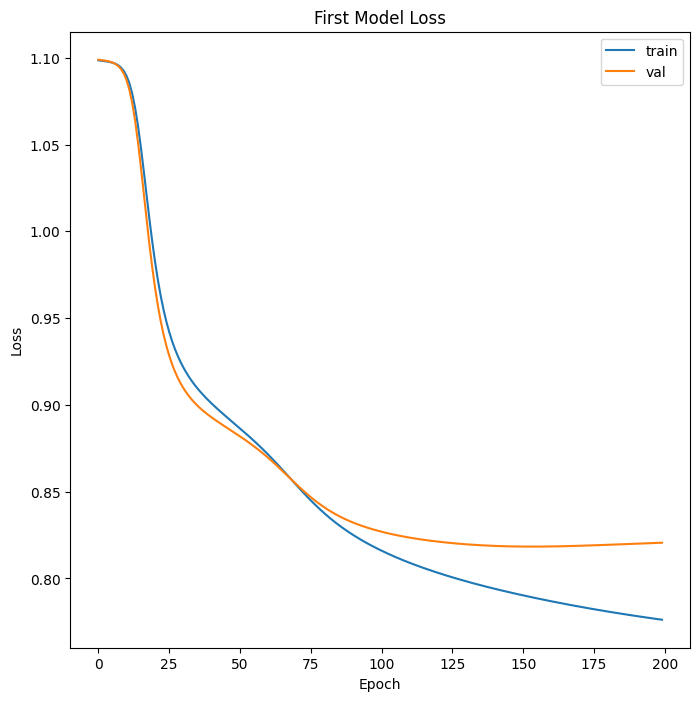

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8,8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model = FFNN(input_dim, hidden_dim_1, hidden_dim_2, output_dim).to(device)

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

FFNN(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=3, bias=True)
)

In [ ]:
#ลองทำนายจากชุดเทส
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
model.eval()
test_prediction = model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.6956 



In [ ]:
# Preprocess the test text
test_text = "พอใช้ได้ ตามราคาค่ะ"
preprocessed_text = remove_duplicate_chars(test_text)

# Convert preprocessed text into TF-IDF vector
tfidf_vector = tfidf_vectorizer.transform([preprocessed_text])

# Convert TF-IDF vector into PyTorch tensor
tfidf_tensor = torch.tensor(tfidf_vector.toarray())

# Move tensor to the appropriate device if GPU is available
tfidf_tensor = tfidf_tensor.to(device)

# Pass the tensor through the trained model to get the prediction
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    prediction = model(tfidf_tensor.float())

# Convert prediction to human-readable label
_, predicted_label = torch.max(prediction, 1)

# Decode the predicted label using the label encoder
predicted_sentiment = encoder.classes_[predicted_label.item()]

print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: Neutrally
